# Patching the Cross Validation Performance of Various Feature Sets v2

The `provean_score` and `ddG` values were used without any threshold. This results in creating undesirable rules for these single feature values.
Here we use either a fixed threshold value or an adaptive threshold value for these single features.


## Balanced Acc and F1 scoress

In [1]:
import os

os.chdir("../")

In [2]:
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import BaseEstimator

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import copy

from tqdm.notebook import tqdm

from src.helpers.helpers_predator.common import load_predator

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [3]:
PREDATOR_PATH = "PredatorModels/PredatorModel_2021-10-24/04f37897/predator.pkl"

In [4]:
predator = load_predator(PREDATOR_PATH)

Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator RandomizedSearchCV from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


2021-12-27 20:49:20 | INFO     | src.helpers.helpers_predator.common | Predator object PredatorModels/PredatorModel_2021-10-24/04f37897/predator.pkl is loaded successfully.


In [5]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [6]:
Xs_ddG = copy.deepcopy(predator.data_materials["Xs_ddG"])
Xs_provean = copy.deepcopy(predator.data_materials["Xs_provean"])
ys = copy.deepcopy(predator.data_materials["ys"])

In [7]:
def get_decision_tree_threshold_val(clf_param):
    text_representation = tree.export_text(clf_param)
    thr_val = float(text_representation.split("\n")[0].split()[-1])
    return thr_val

In [8]:
# class BaselineThresholdClassifier(BaseEstimator):
#     def __init__(self, threshold, classify_func):
#         self.threshold = threshold
#         self.classify_func = classify_func
#
#     def fit(self, X, y=None):
#         pass
#
#     def predict(self, X):
#         return np.array([self.classify_func(val) for val in X["Final_ddG"]])


# class BaselineDeltaDeltaGAdaptiveClassifier(DecisionTreeClassifier):
#     """
#     Uses the threshold value that separates the data instances best.
#     """
#
#     MAX_DEPTH = 1
#
#     def __init__(self, max_depth=MAX_DEPTH):
#         self.max_depth = max_depth
#         super().__init__(max_depth=max_depth)


In [9]:
class BaselineProveanClassifier(BaseEstimator):
    """
    Prediction: "Deleterious" if the score is less than or equal to a predefined threshold.
    For our classification:
        if Provean <= thr:
            deleterious (disrupting, class 0)
        else:
            non deleterious (increasing or no effect, class 1)
    """
    PROVEAN_DEFAULT_THRESHOLD = -2.5
    FEATURE_NAME = "Provean_score"

    def __init__(self, feature_name=FEATURE_NAME, threshold=PROVEAN_DEFAULT_THRESHOLD):
        self.feature_name = feature_name
        self.threshold = threshold

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.array([self.apply_threshold(val) for val in X[self.feature_name]])

    def apply_threshold(self, val):
        if val <= self.threshold:
            return 0  # class 0: disrupting

        else:
            return 1  # class 1: increasing + no effect

In [10]:
class BaselineDeltaDeltaGClassifier(BaseEstimator):
    """
    todo: could not find it explicitly, re check
    """
    DELTA_DELTA_G_DEFAULT_THRESHOLD = 0
    FEATURE_NAME = "Final_ddG"

    def __init__(self, feature_name=FEATURE_NAME, threshold=DELTA_DELTA_G_DEFAULT_THRESHOLD):
        self.feature_name = feature_name
        self.threshold = threshold

    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.array([self.apply_threshold(val) for val in X[self.feature_name]])

    def apply_threshold(self, val):
        if val < self.threshold:
            return 0  # class 0: disrupting

        else:
            return 1  # class 1: increasing + no effect

In [11]:
from sklearn.tree import DecisionTreeClassifier

class BaselineAdaptiveThresholdClassifier(DecisionTreeClassifier):
    """
    Uses the threshold value that separates the data instances best.
    """

    MAX_DEPTH = 1

    def __init__(self, max_depth=MAX_DEPTH):
        self.max_depth = max_depth
        super().__init__(max_depth=max_depth)

In [12]:
foo = DecisionTreeClassifier()
foo.criterion

'gini'

In [13]:
clf = BaselineAdaptiveThresholdClassifier()
clf.fit(Xs_ddG[0][:132], ys[0][:132])
clf.predict(Xs_ddG[0][132:])

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int64)

In [14]:
balanced_accuracy_score(ys[0][132:], clf.predict(Xs_ddG[0][132:]))

0.699134199134199

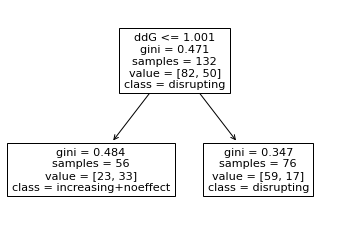

In [15]:
fig = plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [16]:
get_decision_tree_threshold_val(clf)

1.0

In [17]:
X_ddG_sample = Xs_ddG[0]
X_provean_sample = Xs_provean[0]
y_sample = ys[0]

In [18]:
clf = BaselineProveanClassifier()
clf.fit(None, None)
pred = clf.predict(X_provean_sample)
pd.DataFrame(pred).value_counts()

0    144
1     20
dtype: int64

In [19]:
clf = BaselineDeltaDeltaGClassifier()
clf.fit(None, None)
pred = clf.predict(X_ddG_sample)
pd.DataFrame(pred).value_counts()

1    149
0     15
dtype: int64

In [20]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=1)
clf = clf.fit(X_ddG_sample, y_sample)
print(clf.tree_.max_depth)

1


In [21]:
clf.classes_

array([0, 1], dtype=int64)

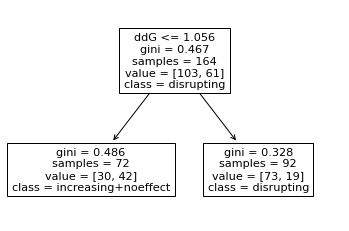

In [22]:
plt.figure()
_ = tree.plot_tree(clf, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"])

In [23]:
get_decision_tree_threshold_val(clf)

1.06

5


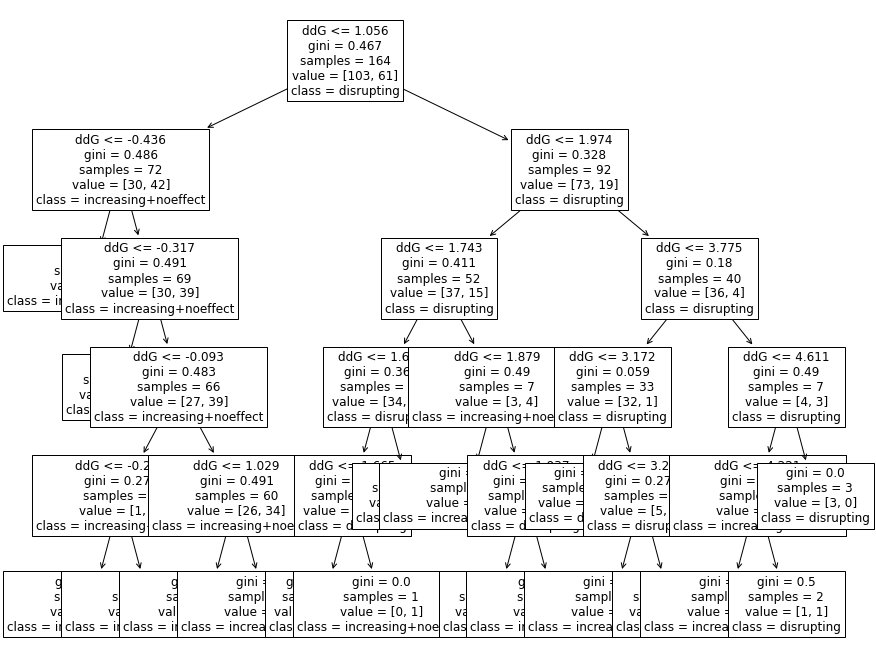

In [24]:
clf_deeper = DecisionTreeClassifier(max_depth=5)
clf_deeper = clf_deeper.fit(X_ddG_sample, y_sample)
print(clf_deeper.tree_.max_depth)
plt.figure(figsize=(14, 12))
tree.plot_tree(clf_deeper, feature_names=["ddG"], class_names=["disrupting", "increasing+noeffect"], fontsize=12);

In [25]:
from src.helpers.helpers_predator.evaluation import cross_val_score_feature_comparison

In [26]:
cross_val_score_feature_comparison(
    X=X_provean_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineProveanClassifier()
)

0.6248

In [27]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineDeltaDeltaGClassifier()
)

0.4422

In [28]:
cross_val_score_feature_comparison(
    X=X_ddG_sample,
    y=y_sample,
    scoring="balanced_accuracy",
    n_repeats=5,
    n_jobs=-2,
    clf=BaselineAdaptiveThresholdClassifier()
)

0.6562

In [29]:
def benchmark_single_features(data_materials):
    Xs_ddG = copy.deepcopy(data_materials["Xs_ddG"])
    Xs_provean = copy.deepcopy(data_materials["Xs_provean"])
    ys = copy.deepcopy(data_materials["ys"])

    ddG_balanced_acc_values = []
    ddG_adaptive_balanced_acc_values = []
    provean_balanced_acc_values = []
    provean_adaptive_balanced_acc_values = []

    ddG_f1_values = []
    ddG_adaptive_f1_values = []
    provean_f1_values = []
    provean_adaptive_f1_values = []

    for X_ddg, X_provean, y in tqdm(zip(Xs_ddG, Xs_provean, ys), total=len(ys)):

        # Balanced Accuracies
        ddG_balanced_acc = cross_val_score_feature_comparison(
            X=X_ddg,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineDeltaDeltaGClassifier()
        )

        ddG_adaptive_balanced_acc = cross_val_score_feature_comparison(
            X=X_ddg,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineAdaptiveThresholdClassifier()
        )

        provean_balanced_acc = cross_val_score_feature_comparison(
            X=X_provean,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineProveanClassifier()
        )

        provean_adaptive_balanced_acc = cross_val_score_feature_comparison(
            X=X_provean,
            y=y,
            scoring="balanced_accuracy",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineAdaptiveThresholdClassifier()
        )

        # F1 scores
        ddG_f1 = cross_val_score_feature_comparison(
            X=X_ddg,
            y=y,
            scoring="f1",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineDeltaDeltaGClassifier()
        )

        ddG_adaptive_f1 = cross_val_score_feature_comparison(
            X=X_ddg,
            y=y,
            scoring="f1",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineAdaptiveThresholdClassifier()
        )

        provean_f1 = cross_val_score_feature_comparison(
            X=X_provean,
            y=y,
            scoring="f1",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineProveanClassifier()
        )

        provean_adaptive_f1 = cross_val_score_feature_comparison(
            X=X_provean,
            y=y,
            scoring="f1",
            n_repeats=5,
            n_jobs=-2,
            clf=BaselineAdaptiveThresholdClassifier()
        )

        ddG_balanced_acc_values.append(ddG_balanced_acc)
        ddG_adaptive_balanced_acc_values.append(ddG_adaptive_balanced_acc)
        provean_balanced_acc_values.append(provean_balanced_acc)
        provean_adaptive_balanced_acc_values.append(provean_adaptive_balanced_acc)

        ddG_f1_values.append(ddG_f1)
        ddG_adaptive_f1_values.append(ddG_adaptive_f1)
        provean_f1_values.append(provean_f1)
        provean_adaptive_f1_values.append(provean_adaptive_f1)

    results_balanced_acc = {
        "$\Delta\Delta$G score only (Fixed threshold)": ddG_balanced_acc_values,
        "$\Delta\Delta$G score only (Adaptive threshold)": ddG_adaptive_balanced_acc_values,
        "Provean score only (Fixed threshold)": provean_balanced_acc_values,
        "Provean score only (Adaptive threshold)": provean_adaptive_balanced_acc_values,
        "METRIC": "BALANCED_ACCURACY",
    }

    results_f1 = {
        "$\Delta\Delta$G score only (Fixed threshold)": ddG_f1_values,
        "$\Delta\Delta$G score only (Adaptive threshold)": ddG_adaptive_f1_values,
        "Provean score only (Fixed threshold)": provean_f1_values,
        "Provean score only (Adaptive threshold)": provean_adaptive_f1_values,
        "METRIC": "F1",
    }

    return results_balanced_acc, results_f1


In [30]:
obtained_results_balanced_acc, obtained_results_f1 = benchmark_single_features(predator.data_materials)

  0%|          | 0/50 [00:00<?, ?it/s]

In [31]:
print(obtained_results_balanced_acc.keys())
print(obtained_results_f1.keys())

dict_keys(['$\\Delta\\Delta$G score only (Fixed threshold)', '$\\Delta\\Delta$G score only (Adaptive threshold)', 'Provean score only (Fixed threshold)', 'Provean score only (Adaptive threshold)', 'METRIC'])
dict_keys(['$\\Delta\\Delta$G score only (Fixed threshold)', '$\\Delta\\Delta$G score only (Adaptive threshold)', 'Provean score only (Fixed threshold)', 'Provean score only (Adaptive threshold)', 'METRIC'])


In [32]:
print(obtained_results_balanced_acc["Provean score only (Fixed threshold)"][:3])
print(obtained_results_f1["Provean score only (Fixed threshold)"][:3])

[0.6242, 0.6078, 0.6538]
[0.3895, 0.378, 0.4672]


In [33]:
single_features_balanced_acc_scores_data = pd.DataFrame(obtained_results_balanced_acc)
single_features_balanced_acc_scores_data = single_features_balanced_acc_scores_data.melt(var_name="FEATURES", value_name="SCORE", id_vars=["METRIC"])
single_features_balanced_acc_scores_data = single_features_balanced_acc_scores_data[['FEATURES', 'METRIC', 'SCORE']]
single_features_balanced_acc_scores_data

,FEATURES,METRIC,SCORE
0,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4423
1,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4650
2,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4028
3,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.3933
4,$\Delta\Delta$G score only (Fixed threshold),BALANCED_ACCURACY,0.4281
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.7057
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.5785
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6652
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6115


In [34]:
single_features_f1_scores_data = pd.DataFrame(obtained_results_f1)
single_features_f1_scores_data = single_features_f1_scores_data.melt(var_name="FEATURES", value_name="SCORE", id_vars=["METRIC"])
single_features_f1_scores_data = single_features_f1_scores_data[['FEATURES', 'METRIC', 'SCORE']]
single_features_f1_scores_data

,FEATURES,METRIC,SCORE
0,$\Delta\Delta$G score only (Fixed threshold),F1,0.4840
1,$\Delta\Delta$G score only (Fixed threshold),F1,0.4878
2,$\Delta\Delta$G score only (Fixed threshold),F1,0.4298
3,$\Delta\Delta$G score only (Fixed threshold),F1,0.4128
4,$\Delta\Delta$G score only (Fixed threshold),F1,0.4393
...,...,...,...
195,Provean score only (Adaptive threshold),F1,0.6148
196,Provean score only (Adaptive threshold),F1,0.3238
197,Provean score only (Adaptive threshold),F1,0.4800
198,Provean score only (Adaptive threshold),F1,0.4057


In [35]:
import seaborn as sns

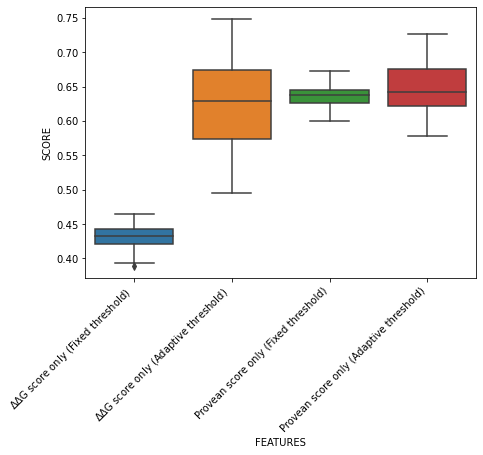

In [36]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=single_features_balanced_acc_scores_data, x="FEATURES", y="SCORE")
plt.xticks(ha='right', rotation=45)
plt.show()

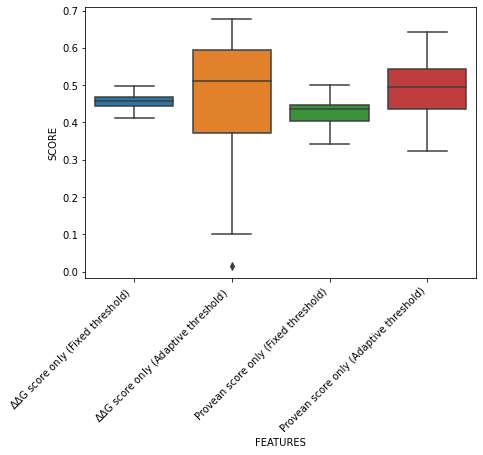

In [37]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=single_features_f1_scores_data, x="FEATURES", y="SCORE")
plt.xticks(ha='right', rotation=45)
plt.show()

In [38]:
def change_shap_top_names(feature_name: str):
    mapping = {
        'Provean': "Provean score only",
        '$\Delta\Delta$G': "$\Delta\Delta$G score only",
        'All Columns': "Predator_all",
        'SHAP Columns (5)': "Predator_SHAP_Top_5",
        'SHAP Columns (10)': "Predator",
        'SHAP Columns (20)': "Predator_SHAP_Top_20",
        'SHAP Columns (30)': "Predator_SHAP_Top_30",
        'SHAP Columns (40)': "Predator_SHAP_Top_40",
    }

    return mapping[feature_name]

In [39]:
scoring_metrics_data_melted = predator.eval_metrics.scoring_metrics_data_melted.copy()
scoring_metrics_data_melted["FEATURES"] = scoring_metrics_data_melted["FEATURES"].apply(lambda x: change_shap_top_names(x))
scoring_metrics_data_melted_balanced_accuracy = scoring_metrics_data_melted[
    scoring_metrics_data_melted["METRIC"].isin(
        ["BALANCED_ACCURACY", "F1"]
    )
].copy()
scoring_metrics_data_melted_balanced_accuracy.drop(["X_NAME", "EXPERIMENT_NO"], axis="columns", inplace=True)
scoring_metrics_data_melted_balanced_accuracy

,FEATURES,METRIC,SCORE
0,Provean score only,F1,0.3957
1,$\Delta\Delta$G score only,F1,0.2854
2,Predator_all,F1,0.4969
3,Predator_SHAP_Top_5,F1,0.5704
4,Predator,F1,0.6410
...,...,...,...
11,Predator_SHAP_Top_5,BALANCED_ACCURACY,0.6553
12,Predator,BALANCED_ACCURACY,0.6433
13,Predator_SHAP_Top_20,BALANCED_ACCURACY,0.6383
14,Predator_SHAP_Top_30,BALANCED_ACCURACY,0.6297


### Concatenate two scoring dataframes

In [40]:
# balanced accuracy and F1 scores are added together
single_features_scores_data_combined = pd.concat(
    [single_features_f1_scores_data, single_features_balanced_acc_scores_data],
    axis='rows'
)
single_features_scores_data_combined

,FEATURES,METRIC,SCORE
0,$\Delta\Delta$G score only (Fixed threshold),F1,0.4840
1,$\Delta\Delta$G score only (Fixed threshold),F1,0.4878
2,$\Delta\Delta$G score only (Fixed threshold),F1,0.4298
3,$\Delta\Delta$G score only (Fixed threshold),F1,0.4128
4,$\Delta\Delta$G score only (Fixed threshold),F1,0.4393
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.7057
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.5785
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6652
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6115


In [41]:
# patched F1 and balanced acc. combined data is concated with previous data
concated_scoring_data = pd.concat(
    [scoring_metrics_data_melted_balanced_accuracy, single_features_scores_data_combined], axis="rows"
)
concated_scoring_data

,FEATURES,METRIC,SCORE
0,Provean score only,F1,0.3957
1,$\Delta\Delta$G score only,F1,0.2854
2,Predator_all,F1,0.4969
3,Predator_SHAP_Top_5,F1,0.5704
4,Predator,F1,0.6410
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.7057
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.5785
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6652
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6115


In [42]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

In [43]:
from pandas.api.types import CategoricalDtype

In [44]:
legend_order = [
    'Provean score only',
    'Provean score only (Fixed threshold)',
    'Provean score only (Adaptive threshold)',
    '$\Delta\Delta$G score only',
    '$\Delta\Delta$G score only (Fixed threshold)',
    '$\Delta\Delta$G score only (Adaptive threshold)',
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order = CategoricalDtype(
    legend_order, ordered=True
)
cat_size_order

CategoricalDtype(categories=['Provean score only', 'Provean score only (Fixed threshold)',
                  'Provean score only (Adaptive threshold)',
                  '$\Delta\Delta$G score only',
                  '$\Delta\Delta$G score only (Fixed threshold)',
                  '$\Delta\Delta$G score only (Adaptive threshold)',
                  'Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [64]:
legend_order_predator = [
    'Predator_all',
    'Predator_SHAP_Top_5',
    'Predator',
    'Predator_SHAP_Top_20',
    'Predator_SHAP_Top_30',
    'Predator_SHAP_Top_40',
]

cat_size_order_predator = CategoricalDtype(
    legend_order_predator, ordered=True
)
cat_size_order_predator

CategoricalDtype(categories=['Predator_all', 'Predator_SHAP_Top_5', 'Predator',
                  'Predator_SHAP_Top_20', 'Predator_SHAP_Top_30',
                  'Predator_SHAP_Top_40'],
, ordered=True)

In [65]:
legend_order_others = [
    'Provean score only (Fixed threshold)',
    '$\Delta\Delta$G score only (Fixed threshold)',
    'Predator',
]

cat_size_order_others = CategoricalDtype(
    legend_order_others, ordered=True
)
cat_size_order_others

CategoricalDtype(categories=['Provean score only (Fixed threshold)',
                  '$\Delta\Delta$G score only (Fixed threshold)', 'Predator'],
, ordered=True)

In [55]:
# concated_scoring_data["FEATURES"] = concated_scoring_data["FEATURES"].astype(cat_size_order)
# concated_scoring_data

,FEATURES,METRIC,SCORE
0,Provean score only,F1,0.3957
1,$\Delta\Delta$G score only,F1,0.2854
2,Predator_all,F1,0.4969
3,Predator_SHAP_Top_5,F1,0.5704
4,Predator,F1,0.6410
...,...,...,...
195,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.7098
196,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.5749
197,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6622
198,Provean score only (Adaptive threshold),BALANCED_ACCURACY,0.6175


In [57]:
# concated_scoring_data = concated_scoring_data.sort_values(["FEATURES"])

# We will create two figures:
## 1. Baselines (fixed thr) and Predator
[18:49, 27/12/2021] Hilal Kazan (ABU CS Prof. ): fixed threshold kalsın
[18:50, 27/12/2021] Hilal Kazan (ABU CS Prof. ): deltadeltag ve provean için fixed threshold
[18:50, 27/12/2021] Hilal Kazan (ABU CS Prof. ): ve sadece Predator

## 2. Predator versions
[18:50, 27/12/2021] Hilal Kazan (ABU CS Prof. ): top5 top10 için supplementary'de ek bir figür yapalım dedik sadece Predator ile ilgili karşılaştırmalar
[18:50, 27/12/2021] Hilal Kazan (ABU CS Prof. ): Böyle olunca figür çok küçülecek o yüzden F1 skoru da ekleyelim dedik balanced accuracy yanı sıra

In [66]:
concated_scoring_data["FEATURES"].value_counts()

Provean score only                                 100
Predator                                           100
Provean score only (Fixed threshold)               100
Predator_SHAP_Top_30                               100
Predator_all                                       100
$\Delta\Delta$G score only (Fixed threshold)       100
$\Delta\Delta$G score only (Adaptive threshold)    100
$\Delta\Delta$G score only                         100
Predator_SHAP_Top_40                               100
Predator_SHAP_Top_5                                100
Provean score only (Adaptive threshold)            100
Predator_SHAP_Top_20                               100
Name: FEATURES, dtype: int64

In [67]:
scoring_data_predator_vs_single_features = concated_scoring_data[
    concated_scoring_data["FEATURES"].isin(
        ["Provean score only (Fixed threshold)", "$\Delta\Delta$G score only (Fixed threshold)", "Predator"]
    )
].copy(deep=True)

In [68]:
scoring_data_predator_vs_single_features["FEATURES"].value_counts()

Provean score only (Fixed threshold)            100
$\Delta\Delta$G score only (Fixed threshold)    100
Predator                                        100
Name: FEATURES, dtype: int64

In [69]:
scoring_data_predator_versions = concated_scoring_data[
    concated_scoring_data["FEATURES"].apply(lambda x: "predator" in x.lower())
].copy(deep=True)

In [70]:
scoring_data_predator_versions["FEATURES"].value_counts()

Predator_all            100
Predator                100
Predator_SHAP_Top_40    100
Predator_SHAP_Top_5     100
Predator_SHAP_Top_30    100
Predator_SHAP_Top_20    100
Name: FEATURES, dtype: int64

## sort them to avoid head ache in plots

In [132]:
scoring_data_predator_vs_single_features_sorted = scoring_data_predator_vs_single_features.copy()
scoring_data_predator_vs_single_features_sorted["FEATURES"] = scoring_data_predator_vs_single_features_sorted["FEATURES"].astype(cat_size_order_others)
scoring_data_predator_vs_single_features_sorted = scoring_data_predator_vs_single_features_sorted.sort_values(["FEATURES", "METRIC"], ascending=[True, False])

In [133]:
scoring_data_predator_versions_sorted = scoring_data_predator_versions.copy()
scoring_data_predator_versions_sorted["FEATURES"] = scoring_data_predator_versions_sorted["FEATURES"].astype(cat_size_order_predator)
scoring_data_predator_versions_sorted = scoring_data_predator_versions_sorted.sort_values(["FEATURES", "METRIC"], ascending=[True, False])

In [134]:
from datetime import datetime

In [135]:
import os.path as op

In [169]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator


def plot_performance_comparison_results(
        scoring_metrics_data_melted,
        metrics,
        filename,
        palette_param,
        figsize=(8, 7),
        export=False,
        overwrite=False,
):
    # sns.set_theme(style="ticks", palette="pastel", font_scale=1.5)  # TODO: POSTER,uncommendLATER
    # sns.set_theme(style="ticks", font_scale=2)  ## palette="pastel"
    sns.set_theme(style="ticks", palette="Set3", font_scale=2)  ## palette="pastel"
    # sns.set_theme(style="white", font_scale=2)  ## palette="pastel"

    # colors_12 = [
    #     # provean
    #     "#F2F2AE",
    #     "#F2C900", # F2DE5C
    #     "#A6915F", # F2C900
    #     # ddG
    #     "#B7E1EE", # B9BFC4, 7FB3C2
    #     "#609BB1", # 609BB1, 24849D
    #     "#105B7A",  # FF616D
    #     # predators
    #     "#F0F1F1", # Predator All  # C6AAB6
    #     "#C6AAB6", # Predator 5  # AC7F93
    #     "#E81123", # Predator 10  # FF616D, F2ECDB, E81123
    #     "#AC7F93", # Predator 20
    #     "#965B77", # Predator 30
    #     "#823960", # Predator 40
    # ]
    # sns.set_palette(sns.color_palette(colors_12))


    # TODO: [later] plot size adjusting itself depending on input ↓
    # plt.figure(figsize=(3 * len(metrics), 7))
    plt.figure(figsize=figsize)
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features\ vs.\ All\ Features"
    # title_string_2 = fr"CV = 10, CV\_repeat = {self.n_repeats}, Experiment\_repeat = {self.n_experiment}"
    # title_string_1 = fr"Performance\ Comparison\ of\ Selected\ Features"
    # title_string_2 = ""
    # title_string_1 = fr"Balanced\ Accuracy\ of\ Feature\ Sets"
    title_string_1 = fr"Performance\ Comparison\ of\ Feature\ Sets"
    title_string_2 = ""
    # plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    # plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontsize=24, fontweight='bold')
    #     plt.title(f"$\mathbf{{{title_string_1}}}$ \n $\mathbf{{{title_string_2}}}$", fontweight='bold')
    plt.title(f"$\mathbf{{{title_string_1}}}$", fontweight='bold')

    plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.8, lw=0.5)
    # noinspection SpellCheckingInspection

    if metrics is not None:
        scoring_metrics_data_melted_less_metrics = scoring_metrics_data_melted[
            scoring_metrics_data_melted['METRIC'].isin(metrics)
        ]
        scoring_metrics_data_plot = scoring_metrics_data_melted_less_metrics

    else:
        scoring_metrics_data_plot = scoring_metrics_data_melted

    # ax = sns.boxplot(x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_melted_less_metrics,
    #                  palette='Pastel1')  # bone, vlag, cividis, #03012d, light:#444452

    ax = sns.boxplot(
        x='METRIC', y='SCORE', hue='FEATURES', data=scoring_metrics_data_plot, saturation=1, palette=palette_param
    )
    # palette='deep')  # bone, vlag, cividis, #03012d, light:#444452

    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.grid(True, which='minor', color='#ababab', lw=1)
    # legend = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), edgecolor="black") ############
    # legend.get_frame().set_alpha(None)
    ###################
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), framealpha=0)
    # plt.tight_layout()  # poster purpose
    # plt.savefig('foo2.png')  # poster purpose


    #     plt.ylabel('Metrics', fontsize=24, fontweight='bold')
    #     plt.ylabel('Balanced Accuracy', fontsize=16, fontweight='bold')
    # plt.ylabel('Balanced Accuracy')
    plt.ylabel('Score')
    #     plt.xlabel('Balanced Accuracy', fontsize=24, fontweight='bold')

    # plt.xticks([])
    plt.xlabel('Metrics', fontsize=24, fontweight='bold')

    if export:
        file_date = datetime.today().strftime('%Y-%m-%d')
        if filename is None:
            filename = f"figures/performance_comparison_selected_features_{file_date}.pdf"
        else:
            filename = f"figures/{filename}_{file_date}.pdf"

        if op.isfile(filename) and not overwrite:
            raise FileExistsError

        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot {filename} is exported.")

    plt.show()
    # sns.despine(offset=10, trim=True)


Plot figures/performance_comparison_provean-ddg-predator_2021-12-28.pdf is exported.


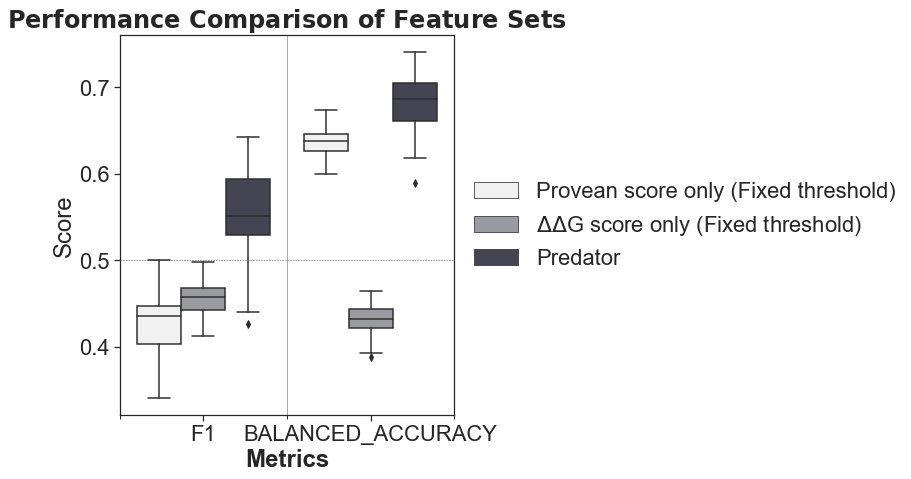

In [173]:
metrics = ["BALANCED_ACCURACY", "F1"]
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_data_predator_vs_single_features_sorted,
    metrics=metrics,
    filename="performance_comparison_provean-ddg-predator",
    palette_param="light:#444452",
    figsize=(6, 7),
    export=True,
    overwrite=False
)

Plot figures/performance_comparison_predator-versions_2021-12-28.pdf is exported.


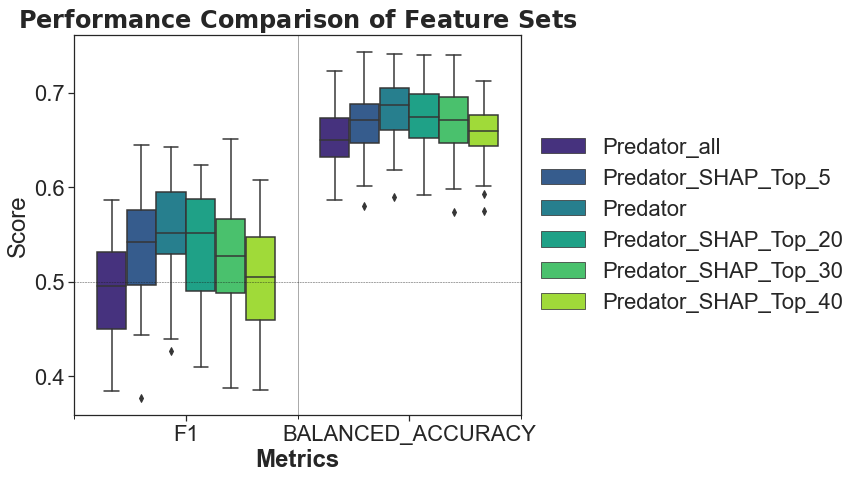

In [174]:
metrics = ["BALANCED_ACCURACY", "F1"]
plot_performance_comparison_results(
    scoring_metrics_data_melted=scoring_data_predator_versions_sorted,
    metrics=metrics,
    filename="performance_comparison_predator-versions",
    palette_param="viridis",
    export=True,
    overwrite=False
)

In [ ]:
"""
default' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
"""

In [ ]:
scoring_data_predator_versions_sorted
scoring_data_predator_vs_single_features_sorted

# Shap

In [145]:
import shap

In [175]:
predator.shap_feature_selector.shap_values_train_list[3][1]

array([[ 0.00675143,  0.03406113,  0.00523423, ...,  0.00746138,
        -0.00178211,  0.00535047],
       [ 0.00284846, -0.0026192 , -0.00526738, ...,  0.00369363,
         0.00448079,  0.00321904],
       [ 0.00484521, -0.00480794, -0.01026411, ...,  0.00458182,
         0.00678581,  0.00550819],
       ...,
       [ 0.00125707, -0.00944052,  0.00016517, ..., -0.00094004,
        -0.00062003, -0.00255416],
       [ 0.01572744,  0.02264897,  0.01721051, ...,  0.00171228,
        -0.00045967,  0.00082454],
       [ 0.00125605, -0.00141458,  0.03295801, ...,  0.00389525,
         0.0142879 ,  0.00376068]])

In [177]:
predator.data_materials["Xs_train"][3]

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
33,0.3333,0.288192,0.9507,0.943866,1.762130,0.982242,0.020935,2.364912,0.177327,-10.467,...,409.0,399.47700,399.61500,49.6587,49.6587,0.000,0.000,0.000,3.39677,3.57761
163,0.9865,0.987175,0.9910,0.493502,-0.311142,0.127309,0.539862,-0.791911,-1.006540,-1.327,...,185.0,16.45670,16.56390,13.9091,13.9091,662.310,363.355,1025.670,5.32063,5.32063
157,1.0000,0.937500,1.0000,0.968254,0.464410,-0.187766,0.012120,0.768550,-0.689732,-3.785,...,123.0,10.30730,10.30320,16.0023,16.0023,591.640,225.475,817.105,2.87629,2.87629
147,0.3417,0.335476,0.5175,0.460785,0.287548,0.015762,0.391345,1.810031,-0.380573,-2.415,...,243.0,73.34630,73.21840,63.0930,63.0930,0.000,0.000,0.000,3.24571,3.79656
21,1.0000,0.978261,0.9716,0.973020,1.620810,0.273011,0.338102,1.395749,-0.004387,-7.146,...,481.0,153.74700,153.22200,79.5901,79.5901,479.295,324.220,803.525,6.73333,5.58818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.0000,0.640000,1.0000,0.987179,2.224760,-0.018164,0.485696,1.558048,-1.506710,-6.433,...,170.0,1.78315,1.75543,31.0296,31.0296,194.670,160.885,355.555,2.69611,2.69611
55,1.0000,0.229885,0.9861,0.617819,2.309700,-0.027639,-0.156049,-1.830079,-0.807864,-4.039,...,132.0,2.78629,2.83554,26.6826,26.6864,329.955,156.225,486.190,3.82571,3.61298
43,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,-9.979,...,244.0,29.53660,33.85950,21.5088,22.8089,505.680,179.230,684.910,3.20023,2.60679
143,0.2830,0.190818,0.3478,0.339285,-0.088324,0.011974,0.044396,-0.565177,0.904373,-0.333,...,404.0,349.99200,349.31200,85.9637,86.0340,424.660,200.115,624.780,3.91026,3.91026


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
33,0.3333,0.288192,0.9507,0.943866,1.762130,0.982242,0.020935,2.364912,0.177327,-10.467,...,409.0,399.47700,399.61500,49.6587,49.6587,0.000,0.000,0.000,3.39677,3.57761
163,0.9865,0.987175,0.9910,0.493502,-0.311142,0.127309,0.539862,-0.791911,-1.006540,-1.327,...,185.0,16.45670,16.56390,13.9091,13.9091,662.310,363.355,1025.670,5.32063,5.32063
157,1.0000,0.937500,1.0000,0.968254,0.464410,-0.187766,0.012120,0.768550,-0.689732,-3.785,...,123.0,10.30730,10.30320,16.0023,16.0023,591.640,225.475,817.105,2.87629,2.87629
147,0.3417,0.335476,0.5175,0.460785,0.287548,0.015762,0.391345,1.810031,-0.380573,-2.415,...,243.0,73.34630,73.21840,63.0930,63.0930,0.000,0.000,0.000,3.24571,3.79656
21,1.0000,0.978261,0.9716,0.973020,1.620810,0.273011,0.338102,1.395749,-0.004387,-7.146,...,481.0,153.74700,153.22200,79.5901,79.5901,479.295,324.220,803.525,6.73333,5.58818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1.0000,0.640000,1.0000,0.987179,2.224760,-0.018164,0.485696,1.558048,-1.506710,-6.433,...,170.0,1.78315,1.75543,31.0296,31.0296,194.670,160.885,355.555,2.69611,2.69611
55,1.0000,0.229885,0.9861,0.617819,2.309700,-0.027639,-0.156049,-1.830079,-0.807864,-4.039,...,132.0,2.78629,2.83554,26.6826,26.6864,329.955,156.225,486.190,3.82571,3.61298
43,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,-9.979,...,244.0,29.53660,33.85950,21.5088,22.8089,505.680,179.230,684.910,3.20023,2.60679
143,0.2830,0.190818,0.3478,0.339285,-0.088324,0.011974,0.044396,-0.565177,0.904373,-0.333,...,404.0,349.99200,349.31200,85.9637,86.0340,424.660,200.115,624.780,3.91026,3.91026


In [180]:
max(predator.data_materials["Xs_train"][9].index)

163

In [ ]:
predator.data_materials["Xs_train"][9]

In [182]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [183]:
predator.data_materials["Xs"][17]

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0.4556,0.479980,1.0000,0.994152,-0.402073,0.204139,0.057368,1.391579,-0.546441,-5.809,...,339.0,58.49900,57.29130,44.29030,44.29030,1726.210,723.565,2449.770,3.31886,3.02838
1,0.9742,0.918665,1.0000,0.911111,0.538351,0.985070,0.395633,1.768714,-1.493130,-4.178,...,235.0,50.98660,50.52340,6.17388,6.17388,765.595,235.955,1001.550,3.68334,5.14410
2,0.7031,0.717945,0.2877,0.248442,1.953510,0.999291,0.978707,2.337643,-0.794557,-4.637,...,382.0,62.21390,63.30310,57.99190,57.99190,499.240,316.330,815.575,4.12981,2.31457
3,1.0000,0.913580,0.9167,0.911372,3.466190,-0.019576,0.273170,1.062391,-1.455530,-9.979,...,244.0,29.53660,33.85950,21.50880,22.80890,505.680,179.230,684.910,3.20023,2.60679
4,0.9815,0.530509,0.9833,0.922627,1.453490,0.547931,0.301686,2.445530,-1.389070,-7.000,...,114.0,11.23150,15.65910,10.96010,10.96010,700.760,240.210,940.970,3.89396,4.53949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.6064,0.340182,0.9809,0.975641,2.516480,-0.088466,0.561741,1.144949,1.020840,-8.573,...,257.0,106.34600,106.07900,103.78800,103.78800,0.000,0.000,0.000,3.43605,2.56962
160,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,0.032483,-0.976256,-0.085671,-5.895,...,118.0,5.30636,3.79101,52.46750,52.46750,427.775,194.715,622.495,3.35293,3.35293
161,1.0000,0.292308,0.9663,0.964737,3.361550,-0.015867,0.104270,0.457039,-1.055320,-4.211,...,689.0,11.53180,11.33020,155.41400,155.41400,288.615,244.200,532.815,2.56253,3.46260
162,0.8333,0.348263,0.8978,0.855388,1.490470,0.063946,-0.065058,-1.328399,-0.057966,-7.597,...,215.0,2.18022,2.18201,52.39200,52.39200,373.020,188.565,561.590,4.12462,4.12462


In [184]:
predator.data_materials["train_data_processed"]

,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,0,Q96QK1,F534D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,0,O43521-3,G66A,Q07812,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0,P84243,Q94A,Q9UER7-3,1.0000,0.948980,1.0000,0.306767,-0.387860,0.995137,...,309.0,21.27130,20.85060,32.4886,32.4886,1159.700,952.745,2112.450,3.00752,4.27950
736,0,Q96QK1,L589D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.178790,0.803401,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
737,0,Q96QK1,L589D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,2.178790,0.803401,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
738,0,P23297,F72L,P25815,0.6778,0.664382,0.5222,0.517348,1.742750,0.889921,...,188.0,26.74010,27.29430,17.1488,16.8699,667.920,288.795,956.720,3.26388,3.30643


In [ ]:
#

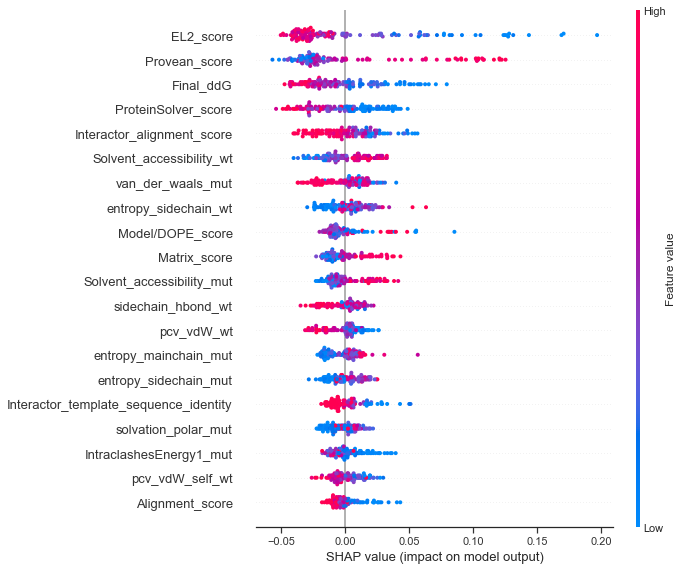

In [146]:
shap.summary_plot(
    predator.shap_feature_selector.shap_values_train_list[3][1],
    predator.data_materials["Xs_train"][3]
)

In [148]:
from sklearn.ensemble import RandomForestClassifier

In [149]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

In [154]:
X_all = predator.data_materials["train_data_processed"].drop(["Mutation_Effect_Label", "UniProt_ID", "Mutation", "Interactor_UniProt_ID"], axis="columns")
X_all

,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,0.032483,-0.976256,-0.085671,-5.895,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,0.272630,2.431782,-0.703858,-8.175,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,1.0000,0.360743,1.0000,0.994505,2.695710,0.288297,0.224558,1.956969,-1.336380,-7.553,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
3,1.0000,0.360743,1.0000,0.973118,2.695710,0.288297,0.224558,1.956969,-1.336380,-7.553,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435
4,1.0000,0.714286,0.3007,0.222028,0.683334,-0.051025,0.849303,-0.000303,-0.321973,-4.158,...,202.0,3.74828,3.76142,41.5937,41.5937,405.510,273.740,679.245,3.37301,3.22505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1.0000,0.948980,1.0000,0.306767,-0.387860,0.995137,0.594040,2.204959,-0.444294,-5.785,...,309.0,21.27130,20.85060,32.4886,32.4886,1159.700,952.745,2112.450,3.00752,4.27950
736,1.0000,0.360743,1.0000,0.994505,2.178790,0.803401,0.135349,1.894254,-1.336380,-6.559,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
737,1.0000,0.360743,1.0000,0.973118,2.178790,0.803401,0.135349,1.894254,-1.336380,-6.559,...,453.0,68.13080,68.12330,59.2629,59.2629,510.690,298.820,809.510,3.45879,3.26826
738,0.6778,0.664382,0.5222,0.517348,1.742750,0.889921,0.458409,0.449541,-1.820240,-5.860,...,188.0,26.74010,27.29430,17.1488,16.8699,667.920,288.795,956.720,3.26388,3.30643


In [155]:
y_all = predator.data_materials["train_data_processed"]["Mutation_Effect_Label"].copy()

In [157]:
model = RandomForestClassifier(random_state=42)
model.fit(X_all, y_all)
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(
    X_all, approximate=False, check_additivity=False
)

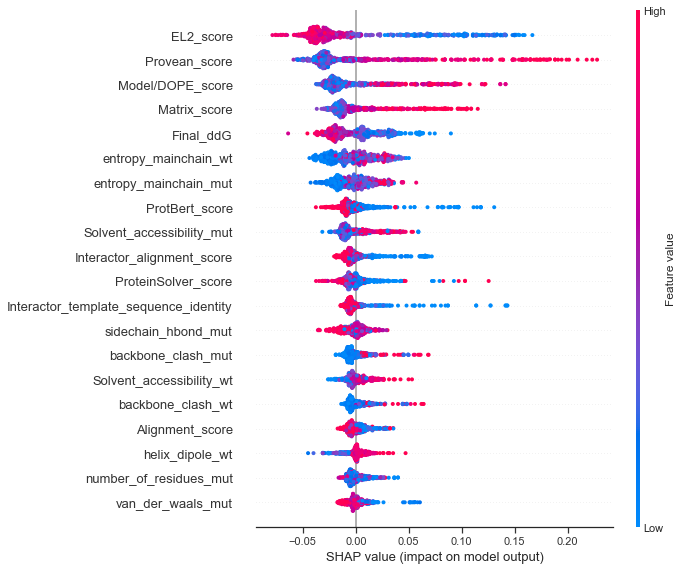

In [159]:
shap.summary_plot(
    shap_values_all[1], X_all
)

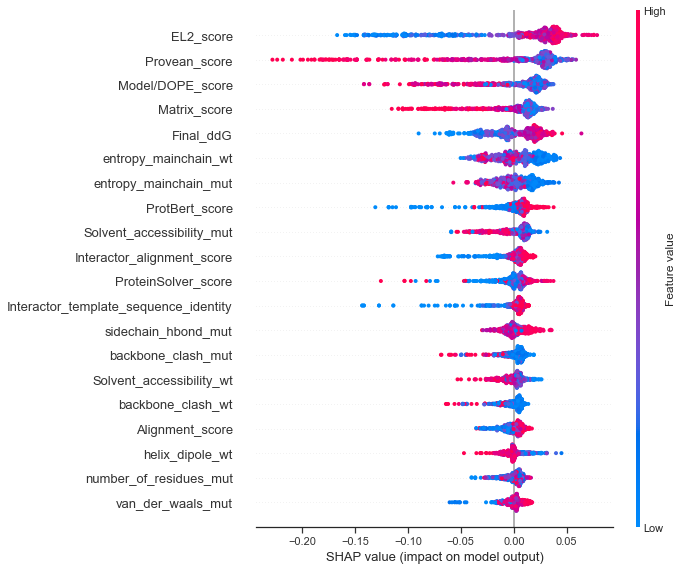

In [160]:
shap.summary_plot(
    shap_values_all[0], X_all
)